In [384]:
#----------------------------#
# Author: Surjit Das
# Email: surjitdas@gmail.com
# Program: artmind
#----------------------------#

import spacy
from spacy import displacy
from loguru import logger as log
import sys

SUBJECT = "SUBJECT"
PREDICATE = "PREDICATE"
OBJECT = "OBJECT"
NER = "NER"
nlp = spacy.load("en_core_web_trf")
LOG_PATH = '/Users/surjitdas/Downloads/nlu_processor/nlu_processor.log'
# log.add(sys.stdout, format="xx{time} {level} {message}", level="INFO")
# log.add(sys.stderr, format="yy{time} {level} {message}", level="INFO")
log.remove()
log.add(LOG_PATH, format="{time} {level} {message}", level="DEBUG")

def pos_it(doc):
    print("|token.text| token.pos_| token.tag_ | token.dep_| token.head.text|")
    for token in doc:
        print(f"|{token.text:<12}| {token.pos_:<10}| {token.tag_:<10}| {token.dep_:<10}| {token.head.text:<12}|")

def chunk_it(doc):
    print(f"|chunk.text:24|chunk.root.text:12|chunk.root.dep_:10|")
    for chunk in doc.noun_chunks:
        print(f"|{chunk.text:24}|{chunk.root.text:12}|{chunk.root.dep_:10}|")

def meaning(doc):
    subject = []
    subject_words = []
    object_words = []
    predicate = []
    object_ = []
    
    for chunk in doc.noun_chunks:
        if 'subj' in chunk.root.dep_:
            subject.append(chunk.text)
            subject_words.extend(chunk.text.split())
        elif 'obj' in chunk.root.dep_ or 'attr' in chunk.root.dep_:
            object_.append(chunk.text)
            object_words.extend(chunk.text.split())
        else:
            predicate.append(chunk.text)

    print(f"{subject_words=}, {object_words=}")

    # for token in doc:
    #     if token.text not in (subject_words + object_words):
    #         # print(f"Inside {token.text=}")
    #         if 'subj' in token.dep_:
    #             subject.append(token.text)
    #             subject_words.append(token.text)
    #         elif 'obj' in token.dep_:
    #             object_.append(token.text)
    #             object_words.append(token.text)
    #         # else:
    #         #     predicate.append(token.text)
    
    _MODS_ = ['acl','advcl', 'advmod', 'oprd', 'xcomp']
    for token in doc:
        if 'ROOT' == token.dep_: # and token.pos_ != 'AUX':
            predicate.append(token.text)
            for child in token.children:
                print(f"{child.text=}, {subject=}, {predicate=}")
                if child.text not in (subject_words + object_words) and child.text not in predicate and child.pos_ not in ['ADP', 'AUX']:
                    predicate.append(child.text)
        elif token.dep_ in _MODS_ and (token.text not in (subject_words + object_words) and token.text not in predicate):
            print(f"{token.text=}")
            predicate.append(token.text)

    ner_dict = {NER:[{ent.text: ent.label_} for ent in doc.ents]}

    interpretation = [
            {SUBJECT:subject},
            {PREDICATE:predicate},
            {OBJECT:object_},
            ner_dict
            ]
    
    # print(interpretation)
    return interpretation

In [524]:
DEP_SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
POS_LINKS = ["AUX","ADP", "CCONJ", "PART"] # more research might be needed here. could do a mix of POS & DEP
DEP_OBJECTS = ["pobj", "dative","oprd"]
DEP_ATTRIBUTES = ["attr"]
DEP_ACTIVITIES = ["dobj"]
POS_NOUN = "NOUN"
DEP_MODIFIERS = ["compound", "npadvmod"]
ADJECTIVES = ["acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm", "hmod", "infmod", "xcomp", "rcmod", "poss"," possessive"] # might need to add this to DEP_X_NOUNS
DEP_X_NOUNS = DEP_OBJECTS + DEP_ATTRIBUTES + DEP_ACTIVITIES + DEP_MODIFIERS
POS_NOUN_CHUNK_MODIFIERS = ["NOUN","PROPN","ADJ", "ADV"]

class algo3:
    def reset_phrases(self):
        return "","-","","",""

    
    # Very tricky function to transform <x's y> or <s' y> as <y of x> or <y of s>
    # To me this is coded as more of a hack rather than with any elegance. But gets the job done
    # The challenge is finding the cases, and then swapping each case; which changes the order
    # and hence needs to be reparsed. So one will find things like the no_of_cases is just used
    # for number of loops and then doc is reparsed to find new indexes of the case, etc.
    def pre_process_1(self, doc):
        log.debug(f"pre_processing: {[[token.i, token.text, token.pos_, token.dep_] for token in doc]}")
        words = [token.text for token in doc]
        no_of_cases = len([token.i for token in doc if token.dep_=="case"])

        if no_of_cases == 0:
            return doc

        for case_i in range(no_of_cases):
            sentence = ' '.join(words)
            sentence = sentence.replace(" '", "'")
            doc = nlp(sentence)
            cases = [token.i for token in doc if token.dep_=="case"]
            case = cases[0] # Since we are popping each case at the end of the loop, the cases[0] always addresses next case
            
            # Find the noun chunk BEFORE case
            noun_chunk_1 = []
            for token in reversed(doc[:case]):
                if token.pos_ in POS_NOUN_CHUNK_MODIFIERS:
                    noun_chunk_1.append(token.i)
                else:
                    break  
    
            # Find the noun chunk AFTER case
            noun_chunk_2 = []
            for token in doc[case+1:] :
                noun_chunk_2.append(token.i)
                if token.pos_ in ["NOUN", "PROPN"]:
                    break

            pop_from = noun_chunk_1[-1]
            insert_at = noun_chunk_2[-1]+1
            words.insert(insert_at, "of")
            for j in noun_chunk_1:
                words.insert(insert_at, words.pop(pop_from))
            words.pop(pop_from)
            log.debug(f"words at end of loop: {words}")
        
        sentence = ' '.join([word for word in words if word not in ("'s", "'")])
        return nlp(sentence)

    def sentencer(self, doc):
        subject_phrase, link_phrase, object_phrase, attribute_phrase, activity_phrase = self.reset_phrases()
        triplets = []
        current_phrase = ""
        source_link = ""
        last_subject = ""
        doc = self.pre_process_1(doc)
        for token in doc:
            current_phrase = f"{current_phrase} {token.text}"
            log.debug(f"1. {current_phrase=}")

            if token.dep_ in DEP_SUBJECTS:
                
                if last_subject != "":
                    triplet = [last_subject, link_phrase, current_phrase.lstrip()]
                    log.debug(f"1.1 {triplet=}")
                    triplets.append(triplet)
                    link_phrase = "-"

                subject_phrase = current_phrase.lstrip()
                last_subject = subject_phrase
                source_link = subject_phrase
                current_phrase = ""
                log.debug(f"2. {subject_phrase=}")
            
            if token.pos_ in POS_LINKS:
                link_phrase = current_phrase.lstrip()
                current_phrase = ""
                log.debug(f"3. {link_phrase=}")

            if token.dep_ in DEP_OBJECTS:
                object_phrase = current_phrase.lstrip()
                current_phrase = ""
                log.debug(f"4.1 {object_phrase=}")

            if token.pos_ == POS_NOUN and token.dep_ not in DEP_X_NOUNS:
                object_phrase = current_phrase.lstrip()
                current_phrase = ""
                log.debug(f"4.2 {object_phrase=}")                

            if token.dep_ in DEP_ATTRIBUTES:
                attribute_phrase = current_phrase.lstrip()
                current_phrase = ""
                log.debug(f"5. {attribute_phrase=}")
            
            if token.dep_ in DEP_ACTIVITIES:
                activity_phrase = current_phrase.lstrip()
                current_phrase = ""
                log.debug(f"6. {activity_phrase=}")

            log.debug(f"7. {source_link=}, {subject_phrase=}, {link_phrase=}, {object_phrase=}, {attribute_phrase=}, {activity_phrase=}, {current_phrase=}, {last_subject=}")

            if len(subject_phrase) > 0 and len(attribute_phrase) > 0:
                triplet = [subject_phrase, link_phrase, attribute_phrase, object_phrase, activity_phrase]
                triplets.append(triplet)
                source_link = attribute_phrase
                subject_phrase, link_phrase, object_phrase, attribute_phrase, activity_phrase = self.reset_phrases()

            if len(source_link) > 0 and (len(object_phrase) > 0 or len(activity_phrase)) :
                triplet = [source_link, link_phrase, attribute_phrase, object_phrase, activity_phrase]
                triplets.append(triplet)
                subject_phrase, link_phrase, object_phrase, attribute_phrase, activity_phrase = self.reset_phrases()        

            log.debug(f"8. {source_link=}, {subject_phrase=}, {link_phrase=}, {object_phrase=}, {attribute_phrase=}, {activity_phrase=}, {current_phrase=}, {last_subject=}")
        
        if len(object_phrase) > 0 or len(attribute_phrase) > 0 or len(activity_phrase) > 0 or len(current_phrase)>0:
            triplet = [source_link, link_phrase, attribute_phrase, object_phrase, activity_phrase, current_phrase]
            triplets.append(triplet)

            
        return triplets


In [527]:
# text = "Diwali is generally a time for visits, exchanging gifts, wearing new clothes, attending feasts, feeding the poor, and lighting fireworks"
# text = "Diwali is generally a time for visits, gifts, new clothes, feasts, feeding the poor, and lighting fireworks"
# text = "Diwali is time for brand new clothes, attending feasts"
# text = "Gujratis go on a shopping spree during Diwali"
# text = "Mumbai is the financial capital of India"
# text = "IBM is a very large company headquartered in USA"
# text = "IBM's headquarters are in USA"
# text = "Donald Trump isn't the worst president of USA, but Hillary Clinton is better than him"
# text = "Thriller is a hit album of Michael Jackson, released in early 1984"
text = "Mortgage renewal process starts 120 days prior to end of term"
# text = "Diwali is known as the Festival of Lights, as people light lamps in their homes and worship Godess Lakshmi"
# text = "Surjit Das is brother of Neha Das"
# text = "The US President is Joe Biden"
# text = "Once upon a time there were three bears"
# text = "Once upon a time there were three bears who lived in a jungle"
# text = "Justin went into a fight unnecessarily"
# text = "IBM's big headquarters are in NY"
# text = "Surjit Das is Neha Das' big brother and Neha is Shikha's daughter"
# text = "It was the very big island's windward side"
# text = "It was the very big island's windward side that had eastern shore's rocks"
# Issues with below. Requires pre or post processing maybe? ===========================================================
# text = "We have a working prototype of a rocket" # works OK for now
# text = "Diwali is known as the Festival of Lights" # ___ of ____ NOUN of NOUN pattern


In [528]:
doc = nlp(text)
# pos_it(doc)
chunk_it(doc)
# print(meaning(doc))
algo = algo3()
print(algo.sentencer(doc))
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

|chunk.text:24|chunk.root.text:12|chunk.root.dep_:10|
|Mortgage renewal process|process     |nsubj     |
|end                     |end         |pobj      |
|term                    |term        |pobj      |
[['Mortgage renewal process', 'starts 120 days prior to', '', 'end', ''], ['Mortgage renewal process', 'of', '', 'term', '']]


In [530]:
algo = algo3()
with open("/Users/surjitdas/Downloads/nlu_processor/Input_2.txt") as fp: 
    lines = fp.readlines() 
    for line in lines:
        doc = nlp(line.rstrip())
        print(algo.sentencer(doc))


[['Baby One More Time', 'is', 'a song', '', ''], ['a song', 'by', '', 'Britney Spears', '']]
[['Diwali', 'is', 'generally a time', '', ''], ['generally a time', 'for', '', 'visits', ''], ['generally a time', '-', '', '', ', exchanging gifts'], ['generally a time', '-', '', '', ', wearing new clothes'], ['generally a time', '-', '', '', ', attending feasts'], ['generally a time', '-', '', '', ', feeding the poor'], ['generally a time', ', and', '', '', 'lighting fireworks']]
[['Diwali', 'is', 'generally a time', '', ''], ['generally a time', 'for', '', 'visits', ''], ['generally a time', '-', '', ', gifts', ''], ['generally a time', '-', '', ', new clothes', ''], ['generally a time', '-', '', ', feasts', ''], ['generally a time', '-', '', '', ', feeding the poor'], ['generally a time', ', and', '', '', 'lighting fireworks']]
[['Diwali', 'known as', '', 'the Festival', ''], ['Diwali', 'of', '', 'Lights', '']]
[['Diwali', 'known as', '', 'the Festival', ''], ['Diwali', 'of', '', 'Lights',

In [6]:
from timefhuman import timefhuman as th
th("thursday") # works
th("1 week ago") # does not work
th("today") # works

datetime.datetime(2021, 11, 15, 0, 0)

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(G, title=None):
    # set figure size
    plt.figure(figsize=(10,5))
    
    # define position of nodes in figure
    pos = nx.nx_agraph.graphviz_layout(G)
    
    # draw nodes and edges
    nx.draw(G, pos=pos, with_labels=True)
    
    # get edge labels (if any)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    
    # draw edge labels (if any)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # plot the title (if any)
    plt.title(title)
    
    plt.show()
    return

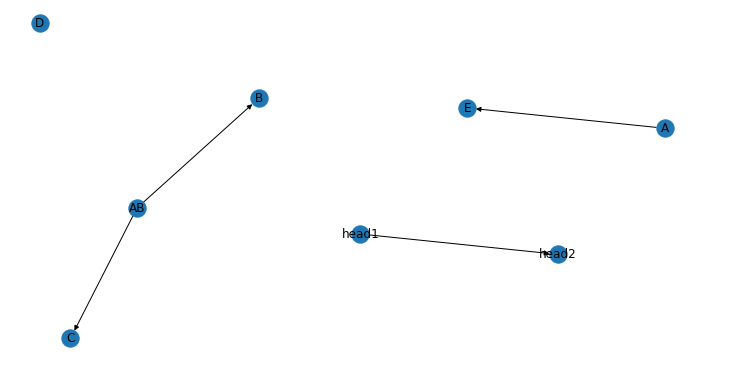

('AB', {'type': 'Set1'})
('B', {'type': 'Set1'})
('C', {'type': 'Set1'})
('D', {'x': 'abc', 'y': 'rytr'})
('E', {'attr': {'e': 'F'}})
('head1', {'attr1': 'attr1_val'})
('head2', {'attr1': 'attr1.1_val'})
('A', {})
AB
found AB
B
C
D
E
head1
head2
A
found A


In [48]:
GRAPHML_PATH = "/Users/surjitdas/Downloads/nlu_processor/test.gexf"
Set1 = ["AB","B","C"]
G1 = nx.MultiDiGraph()
G1.add_nodes_from(Set1, type="Set1")
G1.add_edge("AB","B",label="is")
G1.add_edge("AB","C",label="within")

G2 = nx.MultiDiGraph()
G2.add_node("D")
G2.nodes["D"]["x"]="abc"
G2.nodes["D"]["y"]="rytr"
G2.add_node("E", attr={"e":"F"})


G3 = nx.compose(G1, G2)
head = ("head1", {"attr1":"attr1_val"})
tail = ("head2", {"attr1":"attr1.1_val"})
link = {"Label":"l1", "Type":"Hello"}

G3.add_nodes_from([head, tail])
G3.add_edges_from([(head[0], tail[0], link)])

nx.write_gexf(G3, GRAPHML_PATH)

plot_graph(G3)
for node in G3.nodes(data=True):
    print(node)

for node_label in list(G3.nodes()):
    print(node_label)
    if "A" in node_label:
        print(f"found {node_label}")




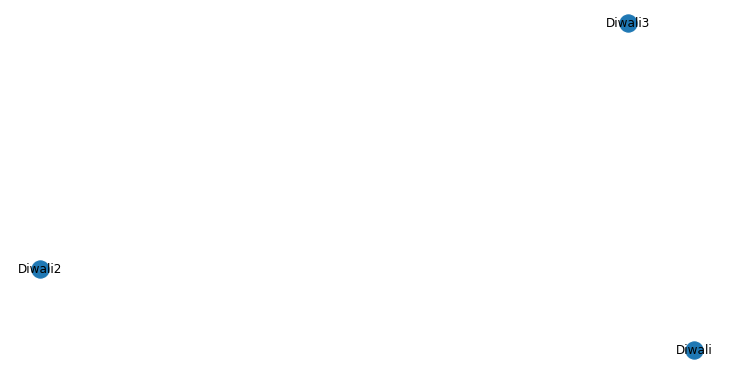

{'type': 'Entity', 'wd': 'b'}


In [28]:
nouns = [['Diwali', {'wd': {'festival': ['recurring event', 'event'], 'holiday': ['recurring event']}}],['Diwali2', {'wd': "a"}]]
G = nx.Graph()
G.add_nodes_from(nouns, type="Entity")
nouns = [['Diwali', {'wd': {'festival': ['recurring event'], 'holiday': ['recurring event','cheap']}}],['Diwali3', {'wd': "b"}]]
G.add_nodes_from(nouns, type="Entity")
plot_graph(G)
# for node in G.nodes(data=True):
#     print(node)
#     print(node[0])
#     for attr in node[1]:
#         print(attr, node[1][attr])
n = dict(G.nodes())['Diwali3']
print(n)

In [11]:
import nlu_processor as nlup

In [12]:
nlup.get_wikidata("Apple")

{'corporation': ['juridical person',
  'company',
  'separate legal entity',
  'organization',
  'legal person',
  'structure',
  'group of humans',
  'person or organization',
  'agent',
  'subject of a right',
  'entity',
  'group of living things',
  'individual entity',
  'subject',
  'continuant',
  'group of physical objects',
  'group',
  'group or class of physical objects',
  'set',
  'collective entity'],
 'trademark': ['symbol',
  'intellectual property',
  'protected name',
  'sign',
  'image',
  'intangible asset',
  'property',
  'name',
  'information',
  'abstract object',
  'word',
  'asset',
  'image',
  'goods',
  'object',
  'non-physical entity',
  'phrase',
  'lexical item',
  'goods and services',
  'resource',
  'entity',
  'signal',
  'data',
  'signal',
  'constituent',
  'language device',
  'linguistic unit',
  'source',
  'continuant',
  'spatio-temporal entity',
  'lexeme',
  'emic unit',
  'mental object',
  'individual entity',
  'class',
  'collective e

In [13]:
nlup.wikifier("Apple")

[{'wikiDataClasses': ['enterprise',
   'business',
   'organization',
   'operation',
   'juridical person',
   'economic unit',
   'agent',
   'group of humans',
   'organizational unit',
   'economic agent',
   'goods',
   'legal person',
   'legal form',
   'unit',
   'individual entity',
   'group of living things',
   'subject',
   'perceptible object',
   'subject of a right',
   'class',
   'abstract object',
   'entity',
   'group of physical objects',
   'structure',
   'physical object',
   'class',
   'object',
   'group',
   'concrete object',
   'physical system',
   'system',
   'scientific object',
   'structure'],
  'DBPEDIATYPES': ['Agent', 'Organisation', 'Company']}]

In [12]:
import requests
CONCEPTNET_API_ENDPOINT_URL = "http://api.conceptnet.io/c/en/"

entity_name = "duck"
limit = 5

url = CONCEPTNET_API_ENDPOINT_URL + entity_name + "?limit=" + str(limit)
print(url)
response = requests.get(url)
response.json()

http://api.conceptnet.io/c/en/duck?limit=5


{'@context': ['http://api.conceptnet.io/ld/conceptnet5.7/context.ld.json'],
 'error': {'details': 'Internal server error', 'status': 500},
 'version': '5.8.1'}

In [29]:
import urllib, json
threshold = 0.8
lang = "en"
text = "sea"
data = urllib.parse.urlencode([
    ("text", text), ("lang", lang),
    ("userKey", "vvswrnlywccfgddhmprbdwviamhnuc") # this is my userkey
    ,
    ("pageRankSqThreshold", "%g" %
        threshold), ("applyPageRankSqThreshold", "false"), # This flag is important - true seems to filter out a lot
    ("nTopDfValuesToIgnore", "100"), ("nWordsToIgnoreFromList", "100"),
    ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
    ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
    ("includeCosines", "false"), ("maxMentionEntropy", "3")
])
url = "http://www.wikifier.org/annotate-article"
# Call the Wikifier and read the response.
req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
with urllib.request.urlopen(req, timeout=60) as f:
    response = f.read()
    response = json.loads(response.decode("utf8"))


In [30]:
response

{'annotations': [{'title': 'Sea',
   'url': 'http://en.wikipedia.org/wiki/Sea',
   'lang': 'en',
   'pageRank': 0.1203093698902812,
   'secLang': 'en',
   'secTitle': 'Sea',
   'secUrl': 'http://en.wikipedia.org/wiki/Sea',
   'wikiDataItemId': 'Q165',
   'wikiDataClasses': [],
   'dbPediaTypes': [],
   'dbPediaIri': 'http://dbpedia.org/resource/Sea',
   'supportLen': 1,
   'support': [{'wFrom': 0,
     'wTo': 0,
     'chFrom': 0,
     'chTo': 2,
     'pMentionGivenSurface': 0.003741906626883908,
     'pageRank': 0.09999999999999999,
     'prbConfidence': 0.133677077655868,
     'entropy': 1.22506605644113}]}],
 'spaces': ['', ''],
 'words': ['sea'],
 'normWords': ['sea'],
 'ranges': [],
 'minPageRank': 0,
 'maxDfThreshold': -1,
 'altLabelSetsUsed': [],
 'linkSourcesAvailable': True,
 'timeTotalMs': 23.689,
 'timeAnnotationMs': 23.689,
 'timeBuildJsonMs': 0,
 'incIdxTimestampUtc': '',
 'fnRegIdx': 'enwiki-20211020-pages-articles-index3.bin',
 'fnWikiData': 'wikidata-20200803-all.bin',
 

In [24]:
wk_dict = {"wikiDataClasses":[],"dbPediaTypes":[]}
for record in response["annotations"]:
    # print(record)
    wdClassList = []
    wikiDataClasses = record['wikiDataClasses']
    for item in wikiDataClasses:
        wdClassList.append(item['enLabel'])
    dbpTypeList = record['dbPediaTypes']

    wk_dict['wikiDataClasses'].extend(wdClassList)
    wk_dict['dbPediaTypes'].extend(dbpTypeList)
wk_dict

{'wikiDataClasses': ['festival',
  'holiday',
  'recurring event',
  'organization',
  'day',
  'event',
  'periodic process',
  'agent',
  'group of humans',
  'time interval',
  'social phenomenon',
  'occurrence',
  'process',
  'individual entity',
  'group of living things',
  'temporal entity',
  'property',
  'phenomenon',
  'occurrent',
  'entity',
  'group of physical objects',
  'structure',
  'spatio-temporal entity',
  'phenomenon',
  'group',
  'object'],
 'dbPediaTypes': ['Holiday']}

In [3]:
wikifier_dict_list = []
for record in response["annotations"]:
    # print(record)
    wk_dict = {}
    wdClassList = []
    wikiDataClasses = record['wikiDataClasses']
    for item in wikiDataClasses:
        wdClassList.append(item['enLabel'])
    dbpTypeList = record['dbPediaTypes']
    wk_dict['wikiDataClasses'] = wdClassList
    wk_dict['dbPediaTypes'] = dbpTypeList
    wikifier_dict_list.append(wk_dict)

wikifier_dict_list
    

{'title': 'Diwali', 'url': 'http://en.wikipedia.org/wiki/Diwali', 'lang': 'en', 'pageRank': 0.7416836334405144, 'secLang': 'en', 'secTitle': 'Diwali', 'secUrl': 'http://en.wikipedia.org/wiki/Diwali', 'wikiDataItemId': 'Q10244', 'wikiDataClasses': [{'itemId': 'Q132241', 'enLabel': 'festival'}, {'itemId': 'Q1445650', 'enLabel': 'holiday'}, {'itemId': 'Q15275719', 'enLabel': 'recurring event'}, {'itemId': 'Q43229', 'enLabel': 'organization'}, {'itemId': 'Q573', 'enLabel': 'day'}, {'itemId': 'Q1656682', 'enLabel': 'event'}, {'itemId': 'Q12044624', 'enLabel': 'periodic process'}, {'itemId': 'Q24229398', 'enLabel': 'agent'}, {'itemId': 'Q16334295', 'enLabel': 'group of humans'}, {'itemId': 'Q186081', 'enLabel': 'time interval'}, {'itemId': 'Q602884', 'enLabel': 'social phenomenon'}, {'itemId': 'Q1190554', 'enLabel': 'occurrence'}, {'itemId': 'Q67518233', 'enLabel': 'process'}, {'itemId': 'Q23958946', 'enLabel': 'individual entity'}, {'itemId': 'Q16334298', 'enLabel': 'group of living things'

[{'wikiDataClasses': ['festival',
   'holiday',
   'recurring event',
   'organization',
   'day',
   'event',
   'periodic process',
   'agent',
   'group of humans',
   'time interval',
   'social phenomenon',
   'occurrence',
   'process',
   'individual entity',
   'group of living things',
   'temporal entity',
   'property',
   'phenomenon',
   'occurrent',
   'entity',
   'group of physical objects',
   'structure',
   'spatio-temporal entity',
   'phenomenon',
   'group',
   'object'],
  'dbPediaTypes': ['Holiday']}]

In [17]:
import conceptnet_lite
conceptnet_lite.connect("/Volumes/Surjit_SSD_1/tech/conceptnet.db")

In [18]:
from conceptnet_lite import Label

cat_concepts = Label.get(text='cat', language='en').concepts  
for c in cat_concepts:
#     print("    Concept URI:", c.uri)
#     print("    Concept text:", c.text)
#     print("    Concept language:", c.language.name)
    e = c.edges_out
    for i in e:
        print(i)

/a/[/r/antonym/,/c/en/cat/,/c/en/dog/]
/a/[/r/antonym/,/c/en/cat/,/c/en/garfield/]
/a/[/r/at_location/,/c/en/cat/,/c/en/africa/]
/a/[/r/at_location/,/c/en/cat/,/c/en/alley/]
/a/[/r/at_location/,/c/en/cat/,/c/en/alleyway/]
/a/[/r/at_location/,/c/en/cat/,/c/en/ally/]
/a/[/r/at_location/,/c/en/cat/,/c/en/american_home/]
/a/[/r/at_location/,/c/en/cat/,/c/en/animal_rescue_shelter/]
/a/[/r/at_location/,/c/en/cat/,/c/en/animal_shops/]
/a/[/r/at_location/,/c/en/cat/,/c/en/apartment/]
/a/[/r/at_location/,/c/en/cat/,/c/en/appartment/]
/a/[/r/at_location/,/c/en/cat/,/c/en/appartments/]
/a/[/r/at_location/,/c/en/cat/,/c/en/arms/]
/a/[/r/at_location/,/c/en/cat/,/c/en/arms_of_human/]
/a/[/r/at_location/,/c/en/cat/,/c/en/art/]
/a/[/r/at_location/,/c/en/cat/,/c/en/attic/]
/a/[/r/at_location/,/c/en/cat/,/c/en/back_alley/]
/a/[/r/at_location/,/c/en/cat/,/c/en/back_yard/]
/a/[/r/at_location/,/c/en/cat/,/c/en/backyard/]
/a/[/r/at_location/,/c/en/cat/,/c/en/bag/]
/a/[/r/at_location/,/c/en/cat/,/c/en/barn/]

In [31]:
from conceptnet_lite import Label, edges_for
text = 'people'
for e in edges_for(Label.get(text=text, language='en').concepts, same_language=True):
    if(e.start.text == text):
        print(f"{e.start.text}-({e.relation.name})->{e.end.text}")

people-(synonym)->people
people-(manner_of)->people
people-(antonym)->animal
people-(antonym)->animals
people-(antonym)->person
people-(at_location)->anus
people-(at_location)->apartment
people-(at_location)->audience
people-(at_location)->bookstore
people-(at_location)->building
people-(at_location)->buildings
people-(at_location)->bus_depot
people-(at_location)->bus_stop
people-(at_location)->car_show
people-(at_location)->carnival
people-(at_location)->city
people-(at_location)->classroom
people-(at_location)->conference
people-(at_location)->confession
people-(at_location)->convention
people-(at_location)->crowds
people-(at_location)->disneyland
people-(at_location)->end_of_line
people-(at_location)->fair
people-(at_location)->football_stadium
people-(at_location)->funeral
people-(at_location)->gallery_opening
people-(at_location)->ground
people-(at_location)->hawaii
people-(at_location)->hockey_game
people-(at_location)->hospital
people-(at_location)->kosher_delicatessen
people-(a

In [6]:
import pandas as pd
df = pd.DataFrame(columns=["a","b"])
row = {"a":"x", "b":"y"}
df = df.append(row, ignore_index=True)
df

,a,b
0,x,y


In [22]:
list1 = {"a":1,"b":2}
list2 = {"a":3,"c":4}
list(zip(list1))

[('a',), ('b',)]

In [36]:
import sqlite3
import pandas as pd
SQL_LOCAL_DB = "/Users/surjitdas/Downloads/nlu_processor1.db"
db = sqlite3.connect(SQL_LOCAL_DB)
COLUMNS = ["token.text","token.dep_","token.pos_"]
text_df = pd.DataFrame(columns=COLUMNS)
row = {"token.text":"aebc","token.dep_":str(["dwwef","sfsdf"]),"token.pos_":304}
text_df = text_df.append(row, ignore_index=True)
text_df.to_sql("paragraph",db,if_exists="append")

In [21]:
import pandas as pd
import math
df = pd.DataFrame({"A":[1,2,3], "B":["a","b","c"]})
row = {"A":4}
df = df.append(row, ignore_index=True)
if str(df["B"][3])=='nan':
    print("found nan")

for index, row in df.iterrows():
    print(row["B"])


found nan
a


TypeError: must be real number, not str

In [19]:
import pandas as pd
import math
import sqlite3
import uuid
SQL_LOCAL_DB = "/Users/surjitdas/Downloads/nlu_processor/test.db"
df = pd.DataFrame({"A":[1,2,3], "B":["a","b","c"], "C":["x","b2","c4"]})
row = {}
row["A"] = 4
row["B"] = str(uuid.uuid4())
df = df.append(row, ignore_index=True)
print(df.to_string())
db = sqlite3.connect(SQL_LOCAL_DB)
df.to_sql("test1", db, index=False, if_exists="append")

   A                                     B    C
0  1                                     a    x
1  2                                     b   b2
2  3                                     c   c4
3  4  aa1dc506-f132-48b0-887e-c8e80b727655  NaN


In [29]:
item = ("'a'",)
sql_str = "select * from test1 where B = ?"
df = pd.read_sql(sql_str,db,params=item)
if len(df) == 0:
    ...
else:
    x = df["A"][0]
    print(x)

In [30]:
import ast
x = "['abc','def']"
y = ast.literal_eval(x)
y

['abc', 'def']

In [39]:
a = []
print(a[:7])


[]


In [116]:
from spacy import displacy
import spacy
nlp = spacy.load("en_core_web_trf")

ROOT = "ROOT"
SUBJECT = "SUBJECT"
PREDICATE = "PREDICATE"
OBJECT = "OBJECT"
COMPOUND = "COMPOUND"
MODIFIER = "MODIFIER"
SUBJECTS = ["nsubj", "nsubjpass", "csubj", "csubjpass", "agent", "expl"]
OBJECTS = ["dobj", "pobj", "dative", "oprd", "attr"] #attr - is an interesting one as Object, removing this makes attr as PREDICATE
COMPOUNDS = ["compound"]
MODIFIERS = ["amod", "advmod", "nummod"]
EXCLUSIONS = ["det", "punct"]
# ADJECTIVES = ["acomp", "advcl", "advmod", "amod", "appos", "nn", "nmod", "ccomp", "complm",
#               "hmod", "infmod", "xcomp", "rcmod", "poss"," possessive"]
# PREPOSITIONS = ["prep"]
# "attr" removed from OBJECTS list. It is further qualifying a predicate or verb

def get_keytype(dep):
    key = ""
    if dep == ROOT:
        key = ROOT
    elif dep in SUBJECTS:
        key = SUBJECT
    elif dep in OBJECTS:
        key = OBJECT
    elif dep in COMPOUNDS:
        key = COMPOUND
    elif dep in MODIFIERS:
        key = MODIFIER
    else:
        key = PREDICATE
    return key

In [117]:
def dfs(token, context):
    item = {}
    key = get_keytype(token.dep_)
    for x,y in context[-1].items():
        last_key = x
        last_value = y
    print(f"key, token.text: {key, token.text}, context: {context}, last_key, last_value: {last_key, last_value}")
    # print(f"context[-1]:{context[-1]}, list(context[-1]): {list(context[-1])}")
    if key == ROOT:
        print("Skipping as key is ROOT...")
    elif last_key != key:
        if (key == COMPOUND): 
            value = f"{token.text} {last_value}"
            print(f"COMPOUND : {last_key}:{value}")
            context[-1] = {last_key:value}
        elif (key == MODIFIER and token in token.head.lefts):
            value = f"{token.text} {last_value}"
            print(f"MODIFIER : {last_key}:{value}")
            context[-1] = {last_key:value}
        else:
            if key == MODIFIER:
                key = PREDICATE
            item[key] = token.text
            print(f"context.append(item): {item}")
            context.append(item)
    else: # if last_key == key
        value = f"{last_value} {token.text}"
        print(f"if last_key == key: key:value : {key}:{value}")
        context[-1] = {key:value}
    print(f"context after adding: {context}")

    for child in token.children:
        # print(f"exploring child {child.text}")
        if(child.dep_ not in EXCLUSIONS):
            dfs(child,context)
    return context


# def process_context(context, spo_list):
#     for item in context:
        
#     return spo_list

In [118]:
# text = "IBM is a very large company that is headquartered in USA"
# text = "IBM is a very large company headquartered in USA"
# text = "IBM is headquartered in USA"
# text = "It is Diwali today in India"
# text = "Mumbai is the capital of Maharashtra"
# text = "Mumbai is the financial capital of India"
# text = "Gujratis go on a shopping spree during Diwali"
text = "Diwali is generally a time for visits, exchanging gifts, wearing new clothes, attending feasts, feeding the poor, and lighting fireworks."
# text = "Diwali is time for brand new clothes and attending feasts"
# text = "Diwali is time for extremely expensive clothes, attending feasts"
# text = "Donald Trump is the worst president of USA"
# text = "Donald Trump isn't the worst president of USA, but Hillary is better than him"
# text = "Baby One More Time is a song by Britney Spears" # This is a difficult one, NER should override as NER recognises Baby One More Time, but Depenency Parsing (DP) is a mess
# text = "Thriller is a hit album of Michael Jackson, released in 1984"
# text = "We have a working prototype of a rocket"
# text = "Diwali is known as the Festival of Lights, as people light lamps in their homes and worship Godess Lakshmi"
text = "Mortgage renewal process starts 120 days prior to end of term"
text = "Once upon a time there were three bears"
doc = nlp(text)
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

for token in doc:
    if (token.dep_ == "ROOT"):
        print (f"{token.text} is the root")
        context = dfs(token,context=[{"ROOT":token.text}])
        print(f"Final context: {context}")
    # print(token.text, token.dep_, spacy.explain(token.dep_), token.pos_, list(token.children), token.left_edge, list(token.lefts), token.right_edge, list(token.rights))
    # print(token.text, token.dep_, spacy.explain(token.dep_), token.pos_, list(token.head.lefts))




were is the root
key, token.text: ('ROOT', 'were'), context: [{'ROOT': 'were'}], last_key, last_value: ('ROOT', 'were')
Skipping as key is ROOT...
context after adding: [{'ROOT': 'were'}]
key, token.text: ('MODIFIER', 'Once'), context: [{'ROOT': 'were'}], last_key, last_value: ('ROOT', 'were')
MODIFIER : ROOT:Once were
context after adding: [{'ROOT': 'Once were'}]
key, token.text: ('PREDICATE', 'upon'), context: [{'ROOT': 'Once were'}], last_key, last_value: ('ROOT', 'Once were')
context.append(item): {'PREDICATE': 'upon'}
context after adding: [{'ROOT': 'Once were'}, {'PREDICATE': 'upon'}]
key, token.text: ('OBJECT', 'time'), context: [{'ROOT': 'Once were'}, {'PREDICATE': 'upon'}], last_key, last_value: ('PREDICATE', 'upon')
context.append(item): {'OBJECT': 'time'}
context after adding: [{'ROOT': 'Once were'}, {'PREDICATE': 'upon'}, {'OBJECT': 'time'}]
key, token.text: ('SUBJECT', 'there'), context: [{'ROOT': 'Once were'}, {'PREDICATE': 'upon'}, {'OBJECT': 'time'}], last_key, last_val

In [119]:
def breakit (item):
    key = ""
    value = ""
    for x, y in item.items():
        key = x
        value = y
    return key, value


In [121]:
# x = [{'ROOT': 'is'}, {'SUBJECT': 'Thriller'}, {'OBJECT': 'hit album'}, {'PREDICATE': 'of'}, {'OBJECT': 'Michael Jackson'}, {'PREDICATE': 'released in'}, {'OBJECT': '1984'}]
# x = [{'ROOT': 'have'}, {'SUBJECT': 'We'}, {'OBJECT': 'working prototype'}, {'PREDICATE': 'of'}, {'OBJECT': 'rocket'}]
x = [{'ROOT': 'is'}, {'SUBJECT': 'Donald Trump'}, {'PREDICATE': "n't"}, {'OBJECT': 'worst president'}, {'PREDICATE': 'of'}, {'OBJECT': 'USA'}, {'PREDICATE': 'but is'}, {'SUBJECT': 'Hillary'}, {'PREDICATE': 'better than'}, {'OBJECT': 'him'}]
# x = [{'ROOT': 'is'}, {'SUBJECT': 'Mumbai'}, {'OBJECT': 'financial capital'}, {'PREDICATE': 'of'}, {'OBJECT': 'India'}]
# x = [{'ROOT': 'is'}, {'SUBJECT': 'Diwali'}, {'PREDICATE': 'generally'}, {'OBJECT': 'time'}, {'PREDICATE': 'for'}, {'OBJECT': 'visits'}, {'PREDICATE': 'exchanging'}, {'OBJECT': 'gifts'}, {'PREDICATE': 'wearing'}, {'OBJECT': 'new clothes'}, {'PREDICATE': 'attending'}, {'OBJECT': 'feasts'}, {'PREDICATE': 'feeding'}, {'OBJECT': 'poor'}, {'PREDICATE': 'and lighting'}, {'OBJECT': 'fireworks'}]
# x = [{'ROOT': 'headquartered'}, {'SUBJECT': 'IBM'}, {'PREDICATE': 'is in'}, {'OBJECT': 'USA'}]
# x = [{'ROOT': 'is'}, {'SUBJECT': 'IBM'}, {'OBJECT': 'very large company'}, {'PREDICATE': 'headquartered'}, {'SUBJECT': 'that'}, {'PREDICATE': 'is in'}, {'OBJECT': 'USA'}]
# x = [{'ROOT': 'is'}, {'SUBJECT': 'Donald Trump'}, {'PREDICATE': "n't"}, {'OBJECT': 'worst president'}, {'PREDICATE': 'of'}, {'OBJECT': 'USA'}, {'PREDICATE': 'but is'}, {'SUBJECT': 'Hillary'}, {'PREDICATE': 'better than'}, {'OBJECT': 'him'}]
x = [{'ROOT': 'starts'}, {'SUBJECT': 'Mortgage renewal process'}, {'PREDICATE': '120 prior days to'}, {'OBJECT': 'end'}, {'PREDICATE': 'of'}, {'OBJECT': 'term'}]
x = [{'ROOT': 'Once were'}, {'PREDICATE': 'upon'}, {'OBJECT': 'time'}, {'SUBJECT': 'there'}, {'OBJECT': 'three bears'}]
print(f"{x[0]=}")
key0, value0 = breakit(x[0])
key2, value2 = breakit(x[2])
y = [x[1]]
if key2 == PREDICATE:
    value2 = f"{value0} {value2}"
    y.append({PREDICATE:value2})
    y.extend(i for i in x[3:])
else:
    y.append({PREDICATE:value0})
    y.extend(i for i in x[2:])

print(y)
subject_q = []
predicate_q = []
spo_list = []
passed_Object = False
for item in y:
    key, value = breakit(item)
    if key == SUBJECT:
        subject_q.append(value)
        spo_list.append([value])
    elif key == PREDICATE:
        spo_list[-1].append(value)
    elif key == OBJECT:
        spo_list[-1].append(value)
        spo_list.append([subject_q[-1]])
        # passed_Object = True

print(spo_list[:-1])
print(subject_q)


x[0]={'ROOT': 'Once were'}
[{'PREDICATE': 'upon'}, {'PREDICATE': 'Once were'}, {'OBJECT': 'time'}, {'SUBJECT': 'there'}, {'OBJECT': 'three bears'}]


IndexError: list index out of range

In [26]:
import py2neo as p2n
NEO4J_USER = 'neo4j'
NEO4J_PASSWORD = "unonothing"
NEO4J_URI = "bolt://localhost:7687"

G_p2n = p2n.Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
# G_p2n.run("UNWIND range(1, 3) AS n RETURN n, n * n as n_sq")
G_p2n.delete_all()

a = p2n.Node("Female", name="Alice", age=5)
G_p2n.create(a)
b  = p2n.Node("Male", name="Bob", age=15)
G_p2n.create(b)

rel = p2n.Relationship.type("likes")

a1 = G_p2n.nodes.match("Female", name="Alice").first()
b1 = G_p2n.nodes.match("Male", name="Bob").first()
link = rel(a1, b1, type="abc")
G_p2n.create(link)

# a.graph, a.identity

In [30]:
import py2neo as p2n
from dataclasses import dataclass
NEO4J_USER = 'neo4j'
NEO4J_PASSWORD = "unonothing"
NEO4J_URI = "bolt://localhost:7687"
G_p2n = p2n.Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
G_p2n.delete_all()

class PhraseNode(p2n.Node):
    def __init__(self, sentence_uuid, phrase, classification):
        super().__init__("Phrase", name=phrase, s_uuid=sentence_uuid, classification=classification)


class PhraseEdge(p2n.Relationship):
    def __init__(self, head, tail, sentence_uuid, phrase, classification):
        self.head = head
        super().__init__(head, phrase, tail, s_uuid=sentence_uuid, classification=classification)

head1 = PhraseNode("3424234", "Adam", "Subject")
tail1 = PhraseNode("3424234", "Eve", "Object")
rel1 = PhraseEdge(head1, tail1, "234322", "-", "Phrase")

head1_1 = PhraseNode("3424234", "Adam", "Subject")
tail2 = PhraseNode("3424234", "Apple", "Object")
rel2 = PhraseEdge(head1_1, tail2, "234322", "-", "Phrase")

# G_p2n.create(rel1)
# G_p2n.create(rel2)

tees = rel1|rel2
G_p2n.create(tees)

head_n4j_node = G_p2n.nodes.match("Phrase", name="Adam")
print(len(head_n4j_node))
print([x for x in head_n4j_node])

print(rel1.head)
rel1.x = "a"
print(rel1.x)



2
[Node('Phrase', classification='Subject', name='Adam', s_uuid='3424234'), Node('Phrase', classification='Subject', name='Adam', s_uuid='3424234')]
(_1439:Phrase {classification: 'Subject', name: 'Adam', s_uuid: '3424234'})
a


In [7]:
import pandas as pd
As = []
As.append(1)
As.append(2)
As.append(3)
Bs = [4,5,6]
data_dict = {"A":As, "B":Bs}
df = pd.DataFrame(data_dict)

df

,A,B
0,1,4
1,2,5
2,3,6


In [2]:
kb_3plets = []
parents = ["a","b","c","d","e"]
i = 0
while True:
    try:
        kb_3plets.append([parents[i], parents[i+1]])
        i = i + 1
    except IndexError:
        break
print(kb_3plets)

[['a', 'b'], ['b', 'c'], ['c', 'd'], ['d', 'e']]


In [5]:
A = set(["Mumbai", "financial", "Maharashtra"])
B = set(["Mumbai", "Maharashtra", "Sameer"])
A-B

{'financial'}

In [17]:
a = ["Michael Jackson", "Thriller"]
A = set((" ").join(a).split())
B = set(["Michael", "Jackson", "song"])
B-A

{'song'}

In [7]:
x = [1,2,3]
y = [5,6,7]
z = zip(x,y)
for i in z:
    print(i)

(1, 5)
(2, 6)
(3, 7)


In [9]:
A = [[1,2],[3,4]]
x, y = zip(*A)
print(x)

(1, 3)
